In [ ]:
from tensorflow.keras.models import Sequential, Model
from keras.layers import Dense, Dropout, UpSampling2D, Conv2DTranspose ,BatchNormalization, MaxPooling2D, Conv2D, MaxPool2D, Flatten, Input, Activation, Concatenate, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf

H = 256
W = 256

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# Build Model

In [ ]:
def double_conv_block(x, num_filters):
  # Conv2D + Relu activation
  x = Conv2D(filters=num_filters, kernel_size=3,padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = Conv2D(filters=num_filters, kernel_size=3,padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

In [ ]:
def downsampling_block(x, num_filters):
  # Double convolution block
  skip_connection = double_conv_block(x, num_filters)
  #MaxPooling
  p = MaxPooling2D(pool_size=2)(skip_connection)
  p = Dropout(0.2)(p)
  return skip_connection, p

In [ ]:
def upsampling_block(x, skip_connection, num_filters):
  # Upsample
  x = Conv2DTranspose(filters=num_filters, kernel_size=2, strides=2, padding="same")(x)
  # Concatenate
  x = Concatenate()([x, skip_connection])
  # Double Conv
  x = double_conv_block(x, num_filters)
  return x

In [ ]:
def U_NET(width, height, channels):
  inputs = Input(shape=(width, height, channels))

  # Encoder
  # downsample 1
  f1, d1 = downsampling_block(inputs, 64)
  # downsample 2
  f2, d2 = downsampling_block(d1,128)
  # downsample 3
  f3, d3 = downsampling_block(d2,256)
  # downsample 4
  f4, d4 = downsampling_block(d3, 512)

  # bottleneck
  bottleneck = double_conv_block(d4, 1024)

  # Decoder
  # upsample 1
  u1 = upsampling_block(bottleneck,f4,512)
  # upsample 2
  u2 = upsampling_block(u1,f3,256)
  # upsample 3
  u3 = upsampling_block(u2,f2,128)
  # upsample 4
  u4 = upsampling_block(u3,f1,64)

  #Output
  outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(u4)

  unet_model = Model(inputs=inputs, outputs=outputs,name="Mini_U-Net")
  return unet_model

In [ ]:
model = U_NET(H,W,3)
model.summary()

Model: "Mini_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_95 (Conv2D)          (None, 256, 256, 64)         1792      ['input_6[0][0]']             
                                                                                                  
 batch_normalization_90 (Ba  (None, 256, 256, 64)         256       ['conv2d_95[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_90 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization

# Prepare data

In [ ]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/DeepLearning/Project/brain_tumor_segmentation.zip -d /content/brain_tumor_segmentation

In [ ]:
from glob import glob
from sklearn.model_selection import train_test_split
import os
path_img = '/content/brain_tumor_segmentation'
def load_data(data_dir, split=0.2):
  images = sorted(glob(os.path.join(data_dir, "images", "*.png")))
  masks = sorted(glob(os.path.join(data_dir, "masks", "*.png")))
  split_size = int(len(images) * split)
  train_x, valid_x = train_test_split(images,test_size=split_size,random_state=42)
  train_y, valid_y = train_test_split(masks,test_size=split_size,random_state=42)

  train_x, test_x = train_test_split(train_x,test_size=split_size, random_state=42)
  train_y, test_y = train_test_split(train_y,test_size=split_size, random_state=42)

  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
def read_image(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = cv2.resize(x, (H,W))
  x  = x/255.0
  x = x.astype(np.float32)
  return x

In [ ]:
def read_mask(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (H,W))
  x = x/255.0
  x = x.astype(np.float32)
  x = np.expand_dims(x, axis=-1)
  return x

In [ ]:
def tf_parse(x,y):
  def _parse(x,y):
    x = read_image(x)
    y = read_mask(y)
    return x,y

  x,y = tf.numpy_function(_parse,[x,y],[tf.float32,tf.float32])
  x.set_shape([H,W,3])
  y.set_shape([H,W,1])
  return x,y

In [ ]:
def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [ ]:
batch_size = 8
lr = 1e-3
num_epochs = 50
model_path = os.path.join('/content/', "model.h5")
csv_path = os.path.join('/content/', "history.csv")

In [ ]:
(train_x, train_y), (valid_x, valid_y),(test_x, test_y) = load_data(path_img)

In [ ]:
print(f"{len(train_x)} - {len(train_y)}")
print(f"{len(valid_x)} - {len(valid_y)}")
print(f"{len(test_x)} - {len(test_y)}")

1840 - 1840
612 - 612
612 - 612


In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size)

# Train & Valid model

### Nếu sử dụng để so sánh mức độ khớp khi giao nhau giữa mask của mô hình so với mask thực tế thì sử dụng các loss và metrics như sau

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

model = U_NET(H,W,3)
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=False),
    ]

Epoch 1/50
230/230 [==============================] - ETA: 0s - loss: 0.7813 - dice_coef: 0.2187
Epoch 1: val_loss improved from inf to 0.95426, saving model to /content/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


230/230 [==============================] - 170s 692ms/step - loss: 0.7813 - dice_coef: 0.2187 - val_loss: 0.9543 - val_dice_coef: 0.0457 - lr: 0.0010
Epoch 2/50
230/230 [==============================] - ETA: 0s - loss: 0.5860 - dice_coef: 0.4140
Epoch 2: val_loss improved from 0.95426 to 0.89718, saving model to /content/model.h5
230/230 [==============================] - 167s 725ms/step - loss: 0.5860 - dice_coef: 0.4140 - val_loss: 0.8972 - val_dice_coef: 0.1031 - lr: 0.0010
Epoch 3/50
230/230 [==============================] - ETA: 0s - loss: 0.5027 - dice_coef: 0.4973
Epoch 3: val_loss improved from 0.89718 to 0.74547, saving model to /content/model.h5
230/230 [==============================] - 170s 737ms/step - loss: 0.5027 - dice_coef: 0.4973 - val_loss: 0.7455 - val_dice_coef: 0.2553 - lr: 0.0010
Epoch 4/50
230/230 [==============================] - ETA: 0s - loss: 0.4634 - dice_coef: 0.5366
Epoch 4: val_loss did not improve from 0.74547
230/230 [==============================]

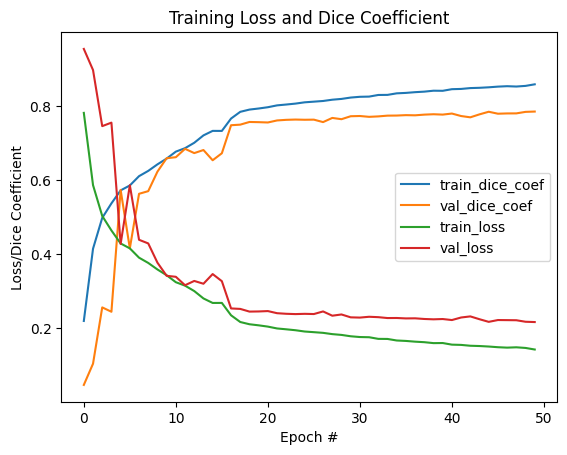

In [ ]:
H = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

print(H.history.keys())
plt.figure()
plt.plot(H.history['dice_coef'], label="train_dice_coef")
plt.plot(H.history['val_dice_coef'], label="val_dice_coef")
plt.plot(H.history['loss'], label = "train_loss")
plt.plot(H.history['val_loss'], label = "val_loss")
plt.title('Training Loss and Dice Coefficient')
plt.ylabel('Loss/Dice Coefficient')
plt.xlabel('Epoch #')
plt.legend()
plt.show()


- Model còn có thể học tốt hơn.

# Test & Evaluate

In [ ]:
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

In [ ]:
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
def save_results(image, mask, y_pred, save_img_path):
  mask = np.expand_dims(mask, axis=-1)
  mask = np.concatenate([mask,mask,mask],axis=-1)

  y_pred = np.expand_dims(y_pred, axis=-1)
  y_pred = np.concatenate([y_pred,y_pred,y_pred],axis=-1)
  y_pred = y_pred*255

  line = np.ones((H,5,3),dtype=np.uint8)*255

  cat_images = np.concatenate([image, line, mask, line, y_pred],axis=1)
  cv2.imwrite(save_img_path, cat_images)

In [ ]:
my_model = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/model.h5'
with CustomObjectScope({"dice_coef":dice_coef,"dice_loss":dice_loss}):
  model = tf.keras.models.load_model(my_model)
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
  # Get path
  name = x.split('/')[-1]
  # Read img & mask
  image = cv2.imread(x, cv2.IMREAD_COLOR)
  image = cv2.resize(image, (H,W))
  x = image/255.0
  x= np.expand_dims(x, axis=0)

  mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
  mask = cv2.resize(mask, (H,W))

  # Predict
  y_pred = model.predict(x,verbose=0)[0]
  y_pred = np.squeeze(y_pred, axis=-1)
  y_pred = (y_pred > 0.5).astype(np.uint8) # Object = 1, Background = 0

  # Save predict
  path_save_pred = '/content/drive/MyDrive/Image/'
  create_dir(path_save_pred +'results_brain_tumor')
  save_img_path = os.path.join(path_save_pred +'results_brain_tumor', name)
  save_results(image, mask, y_pred, save_img_path)

  # Flatten
  mask = (mask > 0.5).astype(np.uint8).flatten()
  y_pred = y_pred.flatten()

  # Caculating metric value
  f1_value = f1_score(mask, y_pred,labels=[0,1], average='binary')
  jac_value = jaccard_score(mask, y_pred,labels=[0,1], average='binary')
  precision_value = precision_score(mask, y_pred,labels=[0,1], average='binary')
  recall_value = recall_score(mask, y_pred,labels=[0,1], average='binary')
  SCORE.append([name, f1_value, jac_value, precision_value, recall_value])

  2%|▏         | 15/612 [00:09<05:08,  1.93it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  7%|▋         | 43/612 [00:18<02:09,  4.40it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 10%|█         | 62/612 [00:23<02:05,  4.39it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [ ]:
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f'F1 Score: {score[0]:0.5f}')
print(f'Jaccard Score: {score[1]:0.5f}')
print(f'Precision Score: {score[2]:0.5f}')
print(f'Recall Score: {score[3]:0.5f}')

F1 Score: 0.69000
Jaccard Score: 0.60236
Precision Score: 0.75635
Recall Score: 0.69380


In [ ]:
df = pd.DataFrame(SCORE, columns=['name', 'f1_score', 'jaccard_score', 'precision_score', 'recall_score'])
df.to_csv('/content/drive/MyDrive/Colab Notebooks/DeepLearning/Project/result_brain_tumor.csv', index=False)